In [1]:
import os
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Masking, Bidirectional, LSTM, TimeDistributed, Dense, Activation

2022-12-31 22:30:12.357717: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-31 22:30:16.137612: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-31 22:30:16.137901: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-31 22:30:16.137940: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
BATCH_SIZE = 256
VALIDATION_RATIO = 0.1

PIECE_LEN = 1024
n_feature = 42
n_hidden = 200
n_pitch = 52
learning_rate = 0.001

## build dataset

In [3]:
def load_npy_data(x_path, y_path, offset):
    x = np.load(x_path)
    y = np.load(y_path)
    if x.shape[0] >= offset+PIECE_LEN:
        return x[offset:offset+PIECE_LEN].astype(np.float64), y[offset:offset+PIECE_LEN].astype(np.float64)
    else:
        pad_count = offset + PIECE_LEN - x.shape[0]
        x = np.pad(x[offset:], ((0, pad_count), (0, 0)), 'constant', constant_values=-1).astype(np.float64)
        y = np.pad(y[offset:], ((0, pad_count), (0, 0)), 'constant', constant_values=-1).astype(np.float64)
        return x, y

def generate_dataset(input_dir: str):
    x_paths = []
    y_paths = []
    offsets = []
    for file_name in sorted(os.listdir(input_dir)):
        if file_name.endswith(".ans.npy"):
            y_path = str(os.path.join(input_dir, file_name))
            x_path = str(os.path.join(input_dir, file_name.replace(".ans.npy", ".npy")))
            assert os.path.exists(x_path), f"corresponding input file {x_path} doesn't exist"
            y_content = np.load(y_path)
            for offset in range(0, y_content.shape[0], PIECE_LEN):
                y_paths.append(y_path)
                x_paths.append(x_path)
                offsets.append(offset)

    
    train_dataset = tf.data.Dataset.from_tensor_slices((x_paths, y_paths, offsets)).shuffle(100000)
    train_dataset = train_dataset.map(lambda x_path, y_path, offset: tf.numpy_function(load_npy_data, [x_path, y_path, offset], [tf.float64, tf.float64]))
    train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(-1).cache()
    
    return train_dataset

In [4]:
train_dataset = generate_dataset("./preprocessed_dataset/augmentation/")

2022-12-31 22:31:04.954037: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 22:31:05.007822: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 22:31:05.008410: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 22:31:05.009811: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## build model

In [5]:
# print("Creating model")
input = tf.keras.Input(shape=(PIECE_LEN, n_feature))  
x = Masking(mask_value=-1, input_shape=(PIECE_LEN, n_feature))(input) # Ignore Padded Data
x = Bidirectional(LSTM(units=n_hidden, input_shape=(1, n_feature), return_sequences=True))(x)
x = TimeDistributed(Dense(n_pitch, activation="softmax"))(x)
model = tf.keras.Model(inputs=input, outputs=x)

# model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
#                 optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#                 metrics=tf.keras.metrics.CategoricalAccuracy())
print(model.summary())

optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024, 42)]        0         
                                                                 
 masking (Masking)           (None, 1024, 42)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 1024, 400)        388800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 1024, 52)         20852     
 ibuted)                                                         
                                                                 
Total params: 409,652
Trainable params: 409,652
Non-trainable params: 0
_________________________________________________________________
None


## loss/accuracy function

In [6]:
def masked_loss_function(y_true, y_pred):
    mask = tf.math.not_equal(tf.reduce_sum(y_true, axis=2), -1*n_pitch)
    loss = tf.losses.categorical_crossentropy(y_true, y_pred)
    mask = tf.cast(mask, loss.dtype)
    loss *= mask
    return tf.reduce_mean(loss)

def masked_accuracy(y_true, y_pred):
    mask = tf.math.not_equal(tf.reduce_sum(y_true, axis=2), -1*n_pitch)
    acc = tf.metrics.categorical_accuracy(y_true, y_pred)
    mask = tf.cast(mask, acc.dtype)
    acc *= mask
    return tf.reduce_mean(acc)

### restore checkpoint

In [7]:
checkpoint_dir = './checkpoints/BDLSTM_Full'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 model=model)

In [8]:
checkpoint.restore(checkpoint_prefix+"-1")

## training

In [9]:
@tf.function
def train_step(x, y):
    loss = 0
    with tf.GradientTape() as tape:
        pred = model(x)
        
        loss = masked_loss_function(y, pred)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    acc = masked_accuracy(y, pred)

    return loss, acc

In [15]:
# set the epochs for training
EPOCHS = 500
loss_history = []

for epoch in range(175,EPOCHS):
    start = time.time()

    # get the initial hidden state of gru
    total_loss = 0
    total_acc = 0
    steps_per_epoch = 0

    for x, y in train_dataset:
        batch_loss, batch_acc = train_step(x, y)
        total_loss += batch_loss
        total_acc += batch_acc
        steps_per_epoch += 1
    
    # saving (checkpoint) the model every 2 epochs
    print(f'Epoch {epoch+1} Loss {total_loss / steps_per_epoch:.4f} Acc {total_acc / steps_per_epoch:.4f}')
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    loss_history.append(float(total_loss / steps_per_epoch))

2022-12-31 22:33:13.908300: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	while inferring type of node 'cond_20/output/_23'
2022-12-31 22:33:14.287768: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8201
2022-12-31 22:33:14.684196: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f88e315f810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-31 22:33:14.684241: I tensorflow/compiler/

Epoch 176 Loss 1.1592 Acc 0.3977
Time taken for 1 epoch 97.81735825538635 sec

Epoch 177 Loss 1.1636 Acc 0.3961
Time taken for 1 epoch 21.35425639152527 sec

Epoch 178 Loss 1.1633 Acc 0.3961
Time taken for 1 epoch 21.385268449783325 sec

Epoch 179 Loss 1.1532 Acc 0.3999
Time taken for 1 epoch 21.432565212249756 sec

Epoch 180 Loss 1.1541 Acc 0.3995
Time taken for 1 epoch 21.504517555236816 sec

Epoch 181 Loss 1.1485 Acc 0.4012
Time taken for 1 epoch 21.505663871765137 sec

Epoch 182 Loss 1.1448 Acc 0.4024
Time taken for 1 epoch 21.48742175102234 sec

Epoch 183 Loss 1.1406 Acc 0.4040
Time taken for 1 epoch 21.587393045425415 sec

Epoch 184 Loss 1.1395 Acc 0.4042
Time taken for 1 epoch 21.652249813079834 sec

Epoch 185 Loss 1.1388 Acc 0.4044
Time taken for 1 epoch 21.61669611930847 sec

Epoch 186 Loss 1.1791 Acc 0.3909
Time taken for 1 epoch 21.716660261154175 sec

Epoch 187 Loss 1.1542 Acc 0.3991
Time taken for 1 epoch 21.720736265182495 sec

Epoch 188 Loss 1.1416 Acc 0.4032
Time taken 

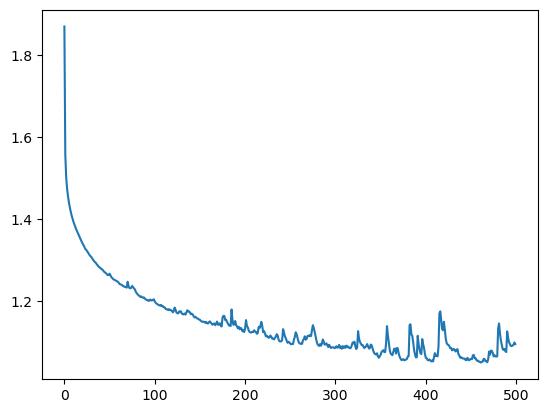

In [16]:
plt.plot(loss_history)

In [17]:
checkpoint.save(checkpoint_prefix)

'./checkpoints/full/ckpt-2'

In [18]:
np.save("full_500.npy", np.array(loss_history))

## predict

In [19]:
def slice_per_step(a, step=PIECE_LEN):
    # add -1 to the end of each sample to make them the same length per step(piece_length)
    pad_count = step - (a.shape[0] % step)
    # print(a.shape, end=' ')
    if pad_count!=step : 
        # print('pad by',pad_count, end=' ')
        a = np.pad(a, ((0, pad_count), (0, 0)), 'constant', constant_values=-1)
    # reshape into per step
    a = np.reshape(a, (-1, step, a.shape[1]))
    # print('to',a.shape)
    return a

In [23]:
import midi_np_translation.output2midi as output2midi

In [25]:
test_file = np.load("preprocessed_dataset/irealpro_midi/Autumn Leaves_o0.mid.npy")
test_result = model.predict(slice_per_step(test_file))
output2midi.output_to_midi(bass_ndarr=test_result.reshape(-1,52), 
                           ref_midi_path="input_midi/irealpro_transposed/Autumn Leaves_o0.mid", 
                           output_path="experiments/BDLSTM_Full/autumn_irealpro.mid")

1/1 [==============================] - 2s 2s/step


In [26]:
test_file = np.load("preprocessed_dataset/dense_jazz/AutumnLeaves_o0.mid.npy")
test_result = model.predict(slice_per_step(test_file))
output2midi.output_to_midi(bass_ndarr=test_result.reshape(-1,52), 
                           ref_midi_path="input_midi/transpose_augmentation/AutumnLeaves_o0.mid", 
                           output_path="experiments/BDLSTM_Full/autumn_arr.mid")

1/1 [==============================] - 0s 33ms/step


In [28]:
test_file = np.load("preprocessed_dataset/dense_jazz/PieceOfMyWish_p1.mid.npy")
test_result = model.predict(slice_per_step(test_file))
output2midi.output_to_midi(bass_ndarr=test_result.reshape(-1,52), 
                           ref_midi_path="input_midi/transpose_augmentation/PieceOfMyWish_p1.mid", 
                           output_path="experiments/BDLSTM_Full/PieceOfMyWish.mid")

1/1 [==============================] - 0s 34ms/step


In [29]:
test_file = np.load("preprocessed_dataset/augmentation/55Dive_o0.mid.npy")
test_result = model.predict(slice_per_step(test_file))
output2midi.output_to_midi(bass_ndarr=test_result.reshape(-1,52), 
                           ref_midi_path="input_midi/transpose_augmentation/55Dive_o0.mid", 
                           output_path="experiments/BDLSTM_Full/55Dive.mid")

1/1 [==============================] - 0s 70ms/step
